In [29]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import (
    LogisticRegression,
    RidgeClassifier,
    SGDClassifier,
    PassiveAggressiveClassifier,
    Perceptron,
)
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.neighbors import (
    KNeighborsClassifier,
    RadiusNeighborsClassifier,
    NearestCentroid,
)
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    VotingClassifier,
)
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import *
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
    BaggingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
)
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from tabulate import tabulate  # Import the tabulate library
from sklearn.neural_network import MLPClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import librosa
import numpy as np

def extract_feature(file_name, mfcc=True, chroma=True, mel=True):
    try:
        # Load the audio file
        audio, sample_rate = librosa.load(file_name, sr=None)
        features = []

        # MFCC
        if mfcc:
            mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
            features.append(np.mean(mfccs.T, axis=0))

        # Chroma
        if chroma:
            stft = np.abs(librosa.stft(audio))
            chroma_features = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
            features.append(np.mean(chroma_features.T, axis=0))

        # Mel Spectrogram
        if mel:
            mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
            mel_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
            features.append(np.mean(mel_db.T, axis=0))

        # Combine all features
        return np.hstack(features)
    except Exception as e:
        print(f"Error in feature extraction: {e}")
        return None


In [15]:
#Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

emotions

{'01': 'neutral',
 '02': 'calm',
 '03': 'happy',
 '04': 'sad',
 '05': 'angry',
 '06': 'fearful',
 '07': 'disgust',
 '08': 'surprised'}

In [17]:
for file in glob.glob("/content/drive/MyDrive/emotion-dataset/Actor_*[0-9]*/*"):
  file_name = os.path.basename(file)
  print(file_name)

03-01-08-02-01-02-22.wav
03-01-06-02-02-01-22.wav
03-01-02-01-01-01-22.wav
03-01-08-01-02-02-22.wav
03-01-06-02-02-02-22.wav
03-01-01-01-01-02-22.wav
03-01-05-02-02-02-22.wav
03-01-06-02-01-01-22.wav
03-01-02-02-01-01-22.wav
03-01-04-02-02-02-22.wav
03-01-02-02-02-02-22.wav
03-01-05-02-02-01-22.wav
03-01-04-02-01-02-22.wav
03-01-04-01-02-02-22.wav
03-01-05-01-02-01-22.wav
03-01-03-02-01-01-22.wav
03-01-08-02-02-01-22.wav
03-01-07-01-02-02-22.wav
03-01-03-01-02-02-22.wav
03-01-03-02-01-02-22.wav
03-01-02-01-01-02-22.wav
03-01-08-01-01-02-22.wav
03-01-05-02-01-02-22.wav
03-01-08-02-01-01-22.wav
03-01-06-02-01-02-22.wav
03-01-07-01-02-01-22.wav
03-01-04-01-01-02-22.wav
03-01-07-02-01-02-22.wav
03-01-05-02-01-01-22.wav
03-01-08-02-02-02-22.wav
03-01-03-02-02-02-22.wav
03-01-05-01-01-02-22.wav
03-01-07-01-01-02-22.wav
03-01-02-02-02-01-22.wav
03-01-05-01-01-01-22.wav
03-01-04-01-02-01-22.wav
03-01-04-02-02-01-22.wav
03-01-07-01-01-01-22.wav
03-01-03-01-01-02-22.wav
03-01-04-02-01-01-22.wav


In [18]:
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(test_size=0.2):
    x, y = [], []
    for file in glob.glob("/content/drive/MyDrive/emotion-dataset/Actor_*[0-9]*/*"):
        file_name = os.path.basename(file)
        print(f"Processing file: {file_name}")
        try:
            emotion_key = file_name.split("-")[2]
            emotion = emotions.get(emotion_key)
            if emotion is None:
                print(f"Skipping file {file_name}: emotion key '{emotion_key}' not found in emotions.")
                continue
            feature = extract_feature(file, mfcc=True, chroma=True, mel=True)
            if feature is None:
                print(f"Feature extraction failed for file: {file}")
                continue
            x.append(feature)
            y.append(emotion)
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

    if not x or not y:
        raise ValueError("No valid data found. Ensure the dataset and mapping are correct.")

    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)


In [19]:
#Split the dataset
x_train,x_test,y_train,y_test=load_data(test_size=0.25)

Processing file: 03-01-07-02-02-02-13.wav
Processing file: 03-01-08-01-01-01-13.wav
Processing file: 03-01-05-01-01-02-13.wav
Processing file: 03-01-07-01-02-01-13.wav
Processing file: 03-01-05-02-02-01-13.wav
Processing file: 03-01-05-02-01-02-13.wav
Processing file: 03-01-07-02-01-01-13.wav
Processing file: 03-01-08-02-02-02-13.wav
Processing file: 03-01-05-02-01-02-06.wav
Processing file: 03-01-04-02-02-01-06.wav
Processing file: 03-01-04-02-01-01-06.wav
Processing file: 03-01-04-02-01-02-06.wav
Processing file: 03-01-04-01-02-01-06.wav
Processing file: 03-01-03-02-02-01-06.wav
Processing file: 03-01-03-02-02-02-06.wav
Processing file: 03-01-04-01-01-01-06.wav
Processing file: 03-01-04-01-01-02-06.wav
Processing file: 03-01-03-02-01-02-06.wav
Processing file: 03-01-04-01-02-02-06.wav
Processing file: 03-01-03-02-01-01-06.wav
Processing file: 03-01-03-01-01-02-06.wav
Processing file: 03-01-03-01-02-02-06.wav
Processing file: 03-01-03-01-02-01-06.wav
Processing file: 03-01-03-01-01-01

In [20]:

print(f"x_train shape: {np.array(x_train).shape}")
print(f"x_test shape: {np.array(x_test).shape}")
print(f"y_train length: {len(y_train)}")
print(f"y_test length: {len(y_test)}")

x_train shape: (1080, 180)
x_test shape: (360, 180)
y_train length: 1080
y_test length: 360


In [21]:
#Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [23]:
# Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [25]:
#Training the model
model.fit(x_train,y_train)


MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [26]:
model.score(x_train, y_train)


0.3787037037037037

In [27]:
#Predict for the test set
y_pred=model.predict(x_test)

#Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 34.72%


In [28]:
y_pred[:10]


array(['surprised', 'angry', 'calm', 'angry', 'surprised', 'calm', 'calm',
       'neutral', 'calm', 'fearful'], dtype='<U9')

In [30]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from tqdm import tqdm
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, LSTM, GRU, Embedding, SimpleRNN, Dropout


# Ignore all warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import *

def evaluate_model(model, x_train, y_train, x_test, y_test):
    # Preprocess 'previous_year_rating' column


    pipe = Pipeline([
        # ('Transform', step1),  # You need to define the 'step1' transformer
        ('model', model),
    ])

    pipe.fit(x_train, y_train)
    y_pred = pipe.predict(x_test)

    # Use appropriate classification metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred,  average="macro")
    f1 = f1_score(y_test, y_pred,  average="macro")

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, precision, recall, f1, cm


# Initialize different classification models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest Classifier': RandomForestClassifier(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'AdaBoost Classifier': AdaBoostClassifier(),
    'Bagging Classifier': BaggingClassifier(),
    'Extra Trees Classifier': ExtraTreesClassifier(),
    'Support Vector Classifier': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB(),
    'HistGradientBoosting Classifier': HistGradientBoostingClassifier(),
    'SGD Classifier': SGDClassifier(),
    'Passive Aggressive Classifier': PassiveAggressiveClassifier(),
    'Ridge Classifier': RidgeClassifier(),
    'MLP Neural Network': MLPClassifier(hidden_layer_sizes=(10,), max_iter=100),

}
# Create a list to store the results
results = []

# Evaluate and print classification metrics for different models
for model_name, model in tqdm(models.items()):
    accuracy, precision, recall, f1, cm = evaluate_model(model, x_train, y_train, x_test, y_test)
    results.append([model_name, accuracy, precision, recall, f1, cm])

# Print the results in a tabular form
headers = ["Model", "Accuracy", "Precision", "Recall", "F1 Score", "Confusion Matrix"]
print(tabulate(results, headers, tablefmt="grid"))

max_accuracy_index = np.argmax([result[1] for result in results])
best_model_name = results[max_accuracy_index][0]
print(f"\nThe model with the highest accuracy is: {best_model_name} (Accuracy: {results[max_accuracy_index][1]:.4f})")

100%|██████████| 15/15 [01:19<00:00,  5.27s/it]

+---------------------------------+------------+-------------+----------+------------+-----------------------------+
| Model                           |   Accuracy |   Precision |   Recall |   F1 Score | Confusion Matrix            |
+=================================+============+=============+==========+============+=============================+
| Logistic Regression             |   0.411111 |    0.369123 | 0.38641  |   0.368235 | [[35  1  5  4  3  0  1  2]  |
|                                 |            |             |          |            |  [ 0 36  4  0  1  2  6  2]  |
|                                 |            |             |          |            |  [ 6  6 18  4  7  1  3  6]  |
|                                 |            |             |          |            |  [ 6  0  1 20  9  1  3  5]  |
|                                 |            |             |          |            |  [11  0  6  6 11  0  4  4]  |
|                                 |            |             |  

In [38]:
def evaluate_model(model, x_train, y_train, x_test, y_test):
    pipe = Pipeline([
        # ('Transform', step1),  # Add step1 if applicable
        ('model', model),
    ])

    pipe.fit(x_train, y_train)
    y_pred = pipe.predict(x_test)

    # Build label mapping
    unique_labels = list(set(class_labels).union(set(y_test)).union(set(y_pred)))
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

    # Convert string labels to numeric labels
    y_test_numeric = np.array([label_mapping[label] for label in y_test if label in label_mapping])
    y_pred_numeric = np.array([label_mapping[label] for label in y_pred if label in label_mapping])

    # Classification metrics
    accuracy = accuracy_score(y_test_numeric, y_pred_numeric)
    precision = precision_score(y_test_numeric, y_pred_numeric, average="macro", zero_division=1)
    recall = recall_score(y_test_numeric, y_pred_numeric, average="macro", zero_division=1)
    f1 = f1_score(y_test_numeric, y_pred_numeric, average="macro", zero_division=1)

    # Confusion matrix
    cm = confusion_matrix(y_test_numeric, y_pred_numeric)

    # ROC and Precision-Recall curves (one-vs-all)
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i, label in enumerate(unique_labels):
        y_test_bin = (y_test_numeric == i).astype(int)
        y_pred_bin = (y_pred_numeric == i).astype(int)

        fpr[label], tpr[label], _ = roc_curve(y_test_bin, y_pred_bin)
        roc_auc[label] = auc(fpr[label], tpr[label])

    # Precision-Recall curve for all classes
    precision_curve = {}
    recall_curve = {}
    for i, label in enumerate(unique_labels):
        y_test_bin = (y_test_numeric == i).astype(int)
        y_pred_bin = (y_pred_numeric == i).astype(int)

        precision_curve[label], recall_curve[label], _ = precision_recall_curve(y_test_bin, y_pred_bin)

    return accuracy, precision, recall, f1, cm, fpr, tpr, roc_auc, precision_curve, recall_curve, unique_labels


In [35]:
print("Unique labels in y_test:", set(y_test))
print("Unique labels in class_labels:", set(class_labels))


Unique labels in y_test: {'disgust', 'calm', 'happy', 'surprised', 'angry', 'sad', 'fearful', 'neutral'}
Unique labels in class_labels: {'08', '01', '05', '04', '03', '02', '07', '06'}


In [36]:
for label in set(y_test).union(set(y_pred)):
    if label not in emotions:
        emotions[label] = label



Model: HistGradientBoosting Classifier
Accuracy: 0.6278
Precision: 0.6292
Recall: 0.6111
F1 Score: 0.6051
Confusion Matrix:
[[23  5  4  6  4  5  3  1]
 [ 0 45  1  0  0  0  0  5]
 [ 4  3 32  0  1  1  3  0]
 [ 1  9  4 20  3  2  5  1]
 [ 3  1  3  3 25  3  4  0]
 [ 3  3  0  2  2 39  2  0]
 [ 0  0  4  2  5  1 33  0]
 [ 0 18  1  2  1  0  0  9]]
ROC AUC per class: {'disgust': 0.7076908433276223, 'calm': 0.8780696744717305, '05': nan, '04': nan, 'surprised': 0.8367376294591484, 'sad': 0.6984126984126984, '02': nan, '07': nan, '06': nan, '08': nan, '01': nan, 'happy': 0.7724618149146452, 'angry': 0.8629354654483152, '03': nan, 'fearful': 0.8396825396825397, 'neutral': 0.6345229924502402}


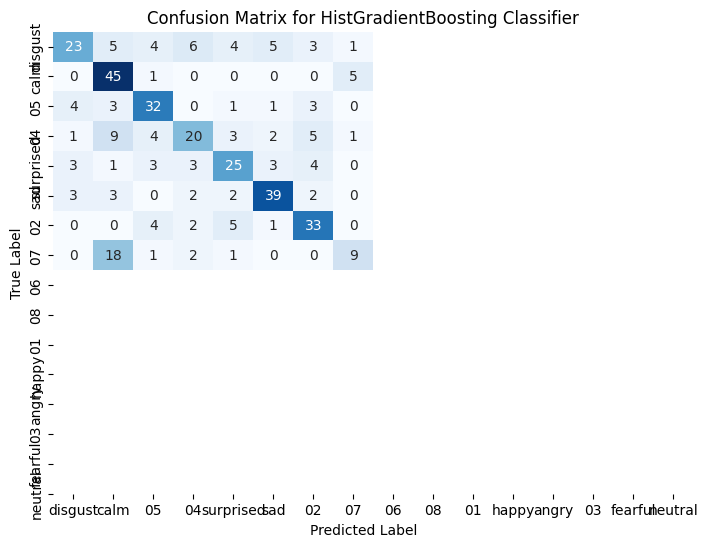

In [40]:
# Evaluate and print classification metrics for different models
for model_name, model in models.items():
    accuracy, precision, recall, f1, cm, fpr, tpr, roc_auc, precision_curve, recall_curve, unique_labels = evaluate_model(model, x_train, y_train, x_test, y_test)

    print(f"\nModel: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"ROC AUC per class: {roc_auc}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(np.arange(len(unique_labels)) + 0.5, unique_labels)
    plt.yticks(np.arange(len(unique_labels)) + 0.5, unique_labels)
    plt.show()

    # # Plot ROC curve (one-vs-all)
    # plt.figure(figsize=(8, 8))
    # for label in unique_labels:
    #     plt.plot(fpr[label], tpr[label], lw=2, label=f"Class {label} (AUC = {roc_auc[label]:.2f})")
    # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title(f'Multiclass ROC Curve for {model_name}')
    # plt.legend(loc='lower right')
    # plt.show()

    # # Plot Precision-Recall curve
    # plt.figure(figsize=(8, 8))
    # for label in unique_labels:
    #     plt.plot(recall_curve[label], precision_curve[label], lw=2, label=f"Class {label}")
    # plt.xlabel('Recall')
    # plt.ylabel('Precision')
    # plt.title(f'Multiclass Precision-Recall Curve for {model_name}')
    # plt.legend(loc='upper right')
    # plt.show()


In [41]:
model

HistGradientBoostingClassifier()

In [42]:

model = model
model.fit(x_train, y_train)  # Training the model

# Calculate metrics on the training set
train_accuracy = accuracy_score(y_train, model.predict(x_train))
train_precision = precision_score(y_train, model.predict(x_train), average='macro')
train_recall = recall_score(y_train, model.predict(x_train), average='macro')
train_f1 = f1_score(y_train, model.predict(x_train), average='macro')

# Calculate metrics on the test set
test_accuracy = accuracy_score(y_test, model.predict(x_test))
test_precision = precision_score(y_test, model.predict(x_test), average='macro')
test_recall = recall_score(y_test, model.predict(x_test), average='macro')
test_f1 = f1_score(y_test, model.predict(x_test), average='macro')

# Create a DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train Set': [train_accuracy, train_precision, train_recall, train_f1],
    'Test Set': [test_accuracy, test_precision, test_recall, test_f1]
})

metrics_df


,Metric,Train Set,Test Set
0,Accuracy,1.0,0.627778
1,Precision,1.0,0.629205
2,Recall,1.0,0.611081
3,F1 Score,1.0,0.605106
